In [ ]:
%%bash
if ! conda env list | grep microexpressions; then
    conda env create -f environment.yml
else
    conda env update -f environment.yml
fi
conda activate microexpressions
dvc pull

In [3]:
import sys
import os
PROJ_PATH = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(PROJ_PATH)

Device: cuda:0

image 1/1 d:\microexpressions\data\raw\celeba\img_align_celeba\000007.jpg: 640x544 1 face, 56.0ms
Speed: 8.3ms preprocess, 56.0ms inference, 107.1ms postprocess per image at shape (1, 3, 640, 544)


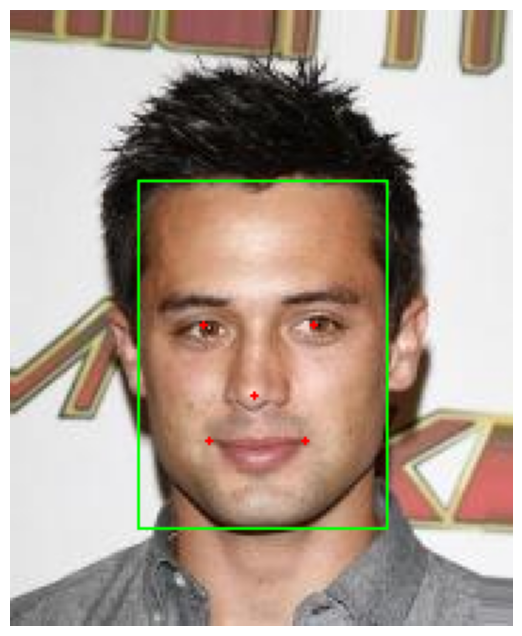

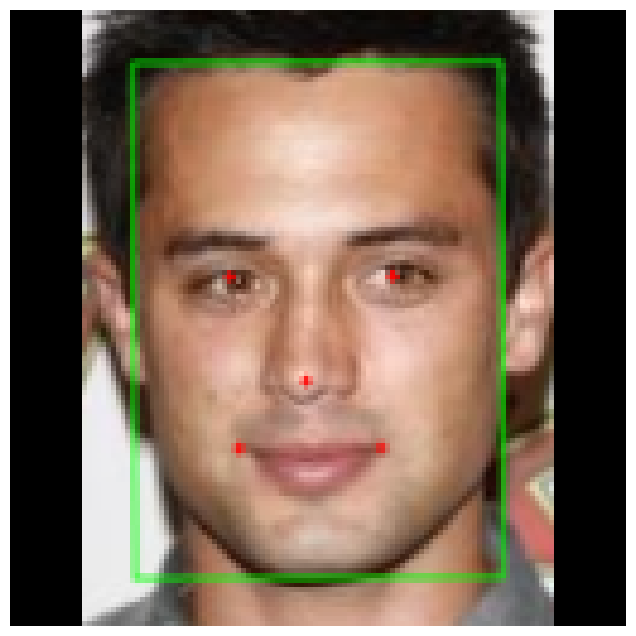

In [4]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
from src.alignment import detect_faces, align_face
import yaml

DATA_DIR = os.path.join(PROJ_PATH, 'data')
MODEL_DIR = os.path.join(PROJ_PATH, 'models')

device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

image_path = os.path.join(DATA_DIR, "raw", "celeba/img_align_celeba", "000007.jpg")
model_path = os.path.join(MODEL_DIR, "yolov8n-face.pt")
image, detections = detect_faces(image_path, model_path, device)

for det in detections:
    x1, y1, x2, y2 = map(int, det["bbox"])
    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 1)
    for x, y in det["landmarks"]:
        cv2.circle(image, (int(x), int(y)), 1, (0, 0, 255), -1)

plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

aligned_image = align_face(image, np.array(detections[0]["landmarks"]), detections[0]["bbox"])
plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(aligned_image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()